## a sub-diffusion code

Producing a self similar analytic solution as $u(x,t)=B(x,t)$ where $B(x,t)$ is a Baranblatt profile, a separable solution $u(x,t)=\frac{-x^2}{6t}$, and a solution similar to the Barenblat profile $u(x,t)=\frac{1}{6}\left[Ct^{-1/3}-\frac{x^2}{t}\right]$.

In [1]:
function barenblatt(x::Float64, t::Float64)
    A=0.16666666666666
    if A >= ((x^2)/(6*(t^0.666666)))
        return (t^(-0.333333333))*(A-((x^2)/(6*(t^0.666666))))
    else
        return 0
    end
end;

function B(x::Array{Float64,1},t::Float64)
    return map(u->barenblatt(u,t),x)
end;

Separable(x,t)=-x^2/(6*t)
SSol(x,t)=map(a->Separable(a,t),x)
Barenblatt_like(x,t)=0.166666666*((36.0/(t^0.333333333))- (x^2)/t)
blSol(x,t)=map(a->Barenblatt_like(a,t),x)

blSol (generic function with 1 method)

In [2]:
X=collect(-499:500);
X=map(x->0.01*x,X);


In [6]:
import Pkg; Pkg.add("Plots");
using Plots;
using LaTeXStrings

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [7]:

pyplot()


Plots.PyPlotBackend()

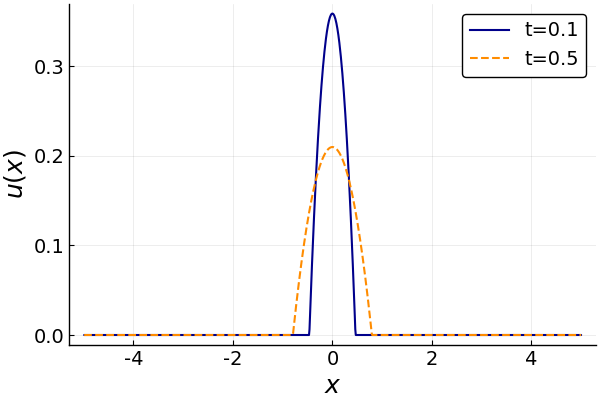

In [37]:
BB=B(X,0.1)
plot(X,B(X,0.1),label="t=0.1",tickfont=font(14),guidefont=font(18), color=:darkblue, legendfontsize=14, linewidth=1.5)
plot!(X,B(X,0.5),label="t=0.5",tickfont=font(14),guidefont=font(18), color=:darkorange, legendfontsize=14, linewidth=1.5,linestyle=:dash)
xlabel!(L"$x$")
ylabel!(L"$u\left(x\right)$")

In [38]:
savefig("Barenblatt.pdf");

#### Globals

In [263]:
h=0.1;
NGH=1;

#### Boundary conditions

In [264]:
function Constant(u::Array{Float64,1},x::Array{Float64,1},t::Float64,K::Float64)
    return K,K
end

function Time_dependant_diffusion(u::Array{Float64,1},x::Array{Float64,1},t::Float64)
    return (-(x[1]^2)/(6.0*t)),(-(x[end]^2)/(6.0*t))
end

function bl_Bound(u::Array{Float64,1},x::Array{Float64,1},t::Float64)
    return Barenblatt_like(x[1],t), Barenblatt_like(x[end],t)
end

function bl_BoundP(u::Array{Float64,1},x::Array{Float64,1},t::Float64)
    return 1.0-Barenblatt_like(x[1],t), 1.0-Barenblatt_like(x[end],t)
end

#Bound(u,x,t)=Constant(u,x,t,0.0)
Bound(u,x,t)=bl_BoundP(u,x,t)

Bound (generic function with 1 method)

#### Spatial discretistion and functions -Central Finite Differences-

In [265]:
∂ₓ(u::Array{Float64,1},i::Int64) = (u[i+1]-u[i-1])/(2.0*h)
∂ₓₓ(u::Array{Float64,1},i::Int64) = (u[i+1]-2.0*u[i]+u[i-1])/(h^2)

D(A::Float64) = 1.0-A
F(u::Array{Float64,1},i::Int64) = u[i]*∂ₓₓ(u,i) + ∂ₓ(u,i)^2
P_dot(p::Array{Float64,1},i::Int64) = (1.0-p[i])*∂ₓₓ(p,i) + ∂ₓ((1.0.-p),i)*∂ₓ(p,i)

P_dot (generic function with 1 method)

#### Time integration -RKL2-

In [266]:
using Base.Threads
println(nthreads())

function b(j)
    J=convert(Float64,j)
    if j < 3
        B=0.33333333333333333
    else
        B=(J^2 + J -2)/(2J*(J+1))
    end
    return B
end

function w(s)
    S=convert(Float64,s)
    W=4/(S^2 + S -2)
    return W
end

function μ(j)
    J=convert(Float64,j)
    MU=((2J-1)/J)*(b(j)/b(j-1))
    return MU
end

function ν(j)
    J=convert(Float64,j)
    NU=-((J-1)/J)*(b(j)/b(j-2))
    return NU
end

μ_2(j,s)=μ(j)*w(s)

function γ_2(j,s)
    GAM=-μ_2(j,s)*(1-b(j-1))
    return GAM
end

function current_time(j::Int,s::Int32)
    J=convert(Float64,j)
    S=convert(Float64,s)
    return (J^2+J-2)/(S^2+S-2)
end

function calc_t_parab(D::Function,D_array::Array{Float64,1},F::Array{Float64,1})
    D_array=map(x->D(x),F)
    t=maximum(abs.(D_array))
    println("max=",t)
    t=0.5*abs((h^2)/t)
    return t
end

function Dot(F::Function,u::Array{Float64,1},result::Array{Float64,1})
    for i=(1+NGH):(length(u)-NGH)
        result[i]=F(u,i)
    end
    return result
end

function Dot(F::Function,u::Array{Float64,1})
    result=deepcopy(u)
    for i=(1+NGH):(length(u)-NGH)
        result[i]=F(u,i)
    end
    return result
end

function step_calc(τ::Float64,t_parab::Float64)
    delta=9+16*(τ/t_parab)
    #println("del=",delta)
    return convert(Int32,ceil(0.5*sqrt(delta)-0.5))
end

function RKL_temparray(u::Array{Float64,1},x::Array{Float64,1},t_now::Float64,
                D_array::Array{Float64,1},F::Function,D::Function,
                atomiτ::Float64,temp::Array{Float64,2})
    s=step_calc(τ,calc_t_parab(D,D_array,u))
    println("steps=",s)
    Y0=u
    temp[:,1]=Y0
    temp[:,2]=Y0+μ_2(1,s)*τ*Dot(F,Y0,temp[:,4])
    temp[1,1],temp[end,1]=Bound(temp[:,1],x,t_now)
    temp[1,2],temp[end,2]=Bound(temp[:,2],x,t_now)
    for j=2:s
        i=((j)%3)+1
        temp[:,i]=μ(j)*temp[:,((j-1)%3)+1] +
                          ν(j)*temp[:,((j-2)%3)+1] +
                          (1-μ(j)-ν(j))*Y0 +
                          μ_2(j,s)*τ*Dot(F,temp[:,((j-1)%3)+1]#=,temp[:,5]=#) +
                          γ_2(j,s)*τ*Dot(F,Y0#=,temp[:,4]=#)
        temp[1,i],temp[end,i]=Bound(temp[:,i],x,t_now+τ*current_time(j,s))
        #println(temp[:,i])
    end
    return temp[:,((s)%3)+1]
end

#function RK4_step(u::Array{Float64,1},D_array::Array{Float64,1},F::Function,D::Function,τ::Float64,temp::Array{Float64,2})
    
function nSteps(n::Int64,init::Array{Float64,1},mesh::Array{Float64,1},
                t_init::Float64,DARRAY_in::Array{Float64,1},F::Function,
                Df::Function,τ::Float64)
    grid=mesh
    DARRAY=DARRAY_in
    TempMatrix=zeros(length(init),5)
    u=deepcopy(init)
    time=t_init
    println("s init=", step_calc(τ,calc_t_parab(D,DARRAY,u)))
    for i=1:n
        u=RKL_temparray(u,grid,time,DARRAY,F,Df,τ,TempMatrix)
        time+=τ
        #println(time,"\n")
        #Sol=hcat(Sol,u)
    end
    return u
end

4


nSteps (generic function with 1 method)

#### Error analysis

In [275]:
∑=sum;
L1(Theoretical::Array{Float64,1}, Numerical::Array{Float64,1})=∑(abs.(Theoretical-Numerical))/(convert(Float64,length(Theoretical)))
Localχ²(Theoretical::Array{Float64,1}, Numerical::Array{Float64,1})=abs.(Theoretical.^2 .- Numerical.^2)
Pnorm(N::Int,Theoretical::Array{Float64,1}, Numerical::Array{Float64,1})=∑(abs.(Theoretical.^N -Numerical.^N))/convert(Float64,length(Theoretical))

Pnorm (generic function with 1 method)

#### Program proper

In [276]:
τ=0.01;
t₀=1.0;

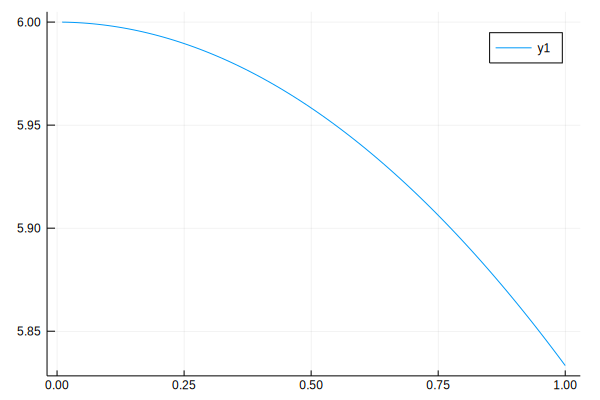

In [277]:
h=1.0/convert(Float64,100);
mesh=map(x->h*x,collect(1:100));
DARRAY=zeros(100);
u=1.0.-(blSol(mesh,t₀))
plot(mesh,1.0.-u)

max=5.999983309333399
s init=69
max=5.999983309333399
steps=69
max=5.98011577931324
steps=69
max=5.960508809281813
steps=69
max=5.9411564773366505
steps=69
max=5.922053051993899
steps=69
max=5.903192984304542
steps=69
max=5.88457090036858
steps=69
max=5.866181594223474
steps=69
max=5.84802002108491
steps=68
max=5.830081290919296
steps=68


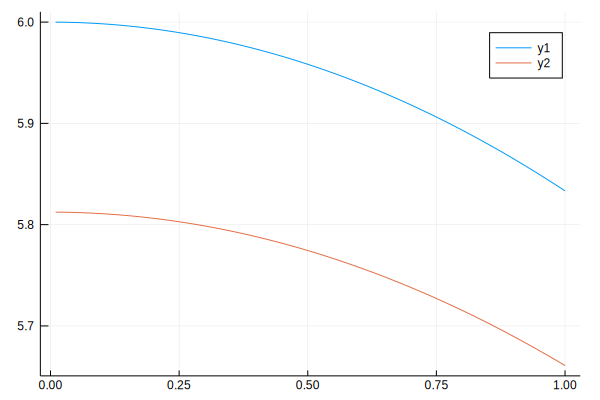

In [278]:
umin=deepcopy(u)
u1= nSteps(10,umin,mesh,t₀,DARRAY,P_dot,D,τ)
plot(mesh,1.0.-u)
plot!(mesh,1.0.-u1)

In [279]:
u=nSteps(50,umin,mesh,t₀,DARRAY,P_dot,D,τ);
u1=nSteps(100,umin,mesh,t₀,DARRAY,P_dot,D,τ);
u2=nSteps(150,umin,mesh,t₀,DARRAY,P_dot,D,τ);

max=5.999983309333399
s init=69
max=5.999983309333399
steps=69
max=5.98011577931324
steps=69
max=5.960508809281813
steps=69
max=5.9411564773366505
steps=69
max=5.922053051993899
steps=69
max=5.903192984304542
steps=69
max=5.88457090036858
steps=69
max=5.866181594223474
steps=69
max=5.84802002108491
steps=68
max=5.830081290919296
steps=68
max=5.81236066232885
steps=68
max=5.794853536731408
steps=68
max=5.777555452818188
steps=68
max=5.7604620812739515
steps=68
max=5.7435692197448756
steps=68
max=5.726872788040499
steps=68
max=5.710368823556907
steps=68
max=5.6940534769091435
steps=68
max=5.6779230077615965
steps=67
max=5.6619737808457815
steps=67
max=5.646202262155613
steps=67
max=5.6306050153108504
steps=67
max=5.615178698079937
steps=67
max=5.599920059054049
steps=67
max=5.584825934464572
steps=67
max=5.569893245136724
steps=67
max=5.555118993572489
steps=67
max=5.540500261156363
steps=67
max=5.5260342054778295
steps=67
max=5.51171805776484
steps=66
max=5.4975491204228435
steps=66
max

max=4.663270973871516
steps=61
max=4.655995992703712
steps=61
max=4.648766197768814
steps=61
max=4.641581100188582
steps=61
max=4.634440218606004
steps=61
max=4.627343079035564
steps=61
max=4.620289214717154
steps=61
max=4.613278165973549
steps=61
max=4.606309480071302
steps=61
max=4.599382711085016
steps=61
max=4.592497419764839
steps=61
max=4.585653173407138
steps=61
max=4.578849545728236
steps=61
max=4.572086116741126
steps=60
max=4.565362472635103
steps=60
max=4.5586782056581985
steps=60
max=4.552032914002368
steps=60
max=4.545426201691339
steps=60
max=4.538857678471056
steps=60
max=4.532326959702644
steps=60
max=4.52583366625783
steps=60
max=4.519377424416742
steps=60
max=4.512957865768052
steps=60
max=4.506574627111344
steps=60
max=4.500227350361722
steps=60
max=4.493915682456528
steps=60
max=4.48763927526416
steps=60
max=4.48139778549491
steps=60
max=4.475190874613792
steps=60
max=4.4690182087552754
steps=60
max=4.4628794586399065
steps=60
max=4.456774299492751
steps=60
max=4.45

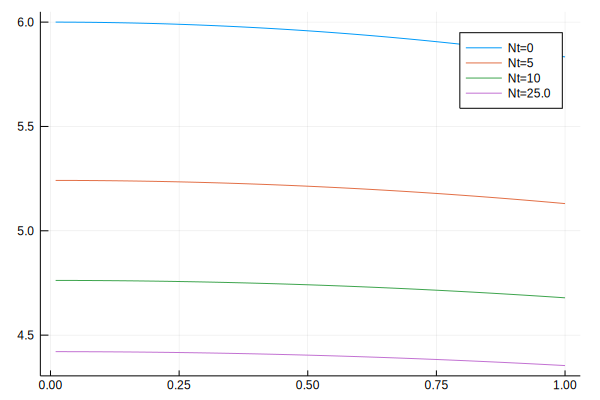

In [280]:
plot(mesh,1.0.-umin,label="Nt=0")
plot!(mesh,1.0.-u,label="Nt=5")
plot!(mesh,1.0.-u1,label="Nt=10")
plot!(mesh,1.0.-u2,label="Nt=25.0")

#### Testing spatial convergence
The spatial convergence is slightly underwhelming, with a below expectation 1.8th order convergence when solving for $f_d$.

Solving for P 

In [291]:
Norm=[]
Norm2=[]
N_Range=10:10:200

10:10:200

In [292]:


for N ∈ collect(N_Range)
    h=1.0/convert(Float64,N);
    println("N=",N)
    mesh=map(x->h*x,collect(1:N));
    DARRAY=zeros(N);
    u=1.0.-(blSol(mesh,t₀));
    umin=deepcopy(u);
    u=nSteps(8,umin,mesh,t₀,DARRAY,P_dot,D,τ);
    Norm=vcat(Norm,Pnorm(2,blSol(mesh,t₀+8.0*τ),1.0.-u));
end


N=10
max=5.99833330934
s init=7
max=5.99833330934
steps=7
max=5.9784821159534385
steps=7
max=5.9588911622294605
steps=7
max=5.939554535595485
steps=7
max=5.920466513538705
steps=7
max=5.901621555739399
steps=7
max=5.883014296601221
steps=7
max=5.864639538154876
steps=7
N=20
max=5.999583309335
s init=14
max=5.999583309335
steps=14
max=5.979719739710865
steps=14
max=5.960116652420637
steps=14
max=5.94076812782364
steps=14
max=5.921668436610821
steps=14
max=5.902812031925113
steps=14
max=5.884193541879523
steps=14
max=5.865807762449269
steps=14
N=30
max=5.999814790815556
s init=21
max=5.999814790815556
steps=21
max=5.979948929295572
steps=21
max=5.960343595048632
steps=21
max=5.940992867125151
steps=21
max=5.9218910149575095
steps=21
max=5.903032490478024
steps=21
max=5.884411920634764
steps=21
max=5.866024100281564
steps=21
N=40
max=5.99989580933375
s init=28
max=5.99989580933375
steps=28
max=5.980029145650221
steps=28
max=5.9604230249684305
steps=28
max=5.941071525880679
steps=28
max=5.

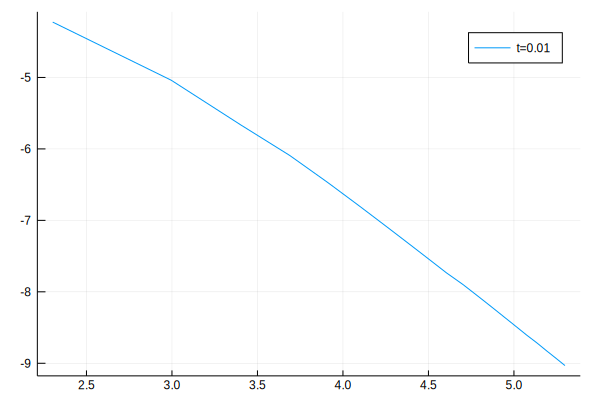

In [293]:
plot(log.(collect(N_Range)),log.(Norm),label="t=0.01")

In [294]:
(log(Norm[1])-log(Norm[end]))/(log(collect(N_Range)[1])-log(collect(N_Range)[end]))

-1.6044679422862287

#### Testing convergence in t
The scheme is briefly superconvergence, quickly reaching maximum accuracy

In [76]:
h=1.0/convert(Float64,100);
mesh=map(x->h*x,collect(1:100));
t₀=1.0;
DARRAY=zeros(100);

In [123]:
NormT=[]
τ_array=[]


for N ∈ collect(1:1:100)
    τ=1.0/N
    u=blSol(mesh,t₀);
    umin=deepcopy(u);
    u=nSteps(N,umin,mesh,t₀,DARRAY,F,D,τ);
    NormT=vcat(NormT,L1(blSol(mesh,t₀+1.0),u));
    τ_array=vcat(τ_array,τ);
    #println(N)
end


s init=849
1
s init=600
2
s init=490
3
s init=424
4
s init=379
5
s init=346
6
s init=321
7
s init=300
8
s init=283
9
s init=268
10
s init=256
11
s init=245
12
s init=235
13
s init=227
14
s init=219
15
s init=212
16
s init=206
17
s init=200
18
s init=195
19
s init=190
20
s init=185
21
s init=181
22
s init=177
23
s init=173
24
s init=170
25
s init=166
26
s init=163
27
s init=160
28
s init=158
29
s init=155
30
s init=152
31
s init=150
32
s init=148
33
s init=146
34
s init=143
35
s init=141
36
s init=140
37
s init=138
38
s init=136
39
s init=134
40
s init=133
41
s init=131
42
s init=129
43
s init=128
44
s init=126
45
s init=125
46
s init=124
47
s init=122
48
s init=121
49
s init=120
50
s init=119
51
s init=118
52
s init=117
53
s init=115
54
s init=114
55
s init=113
56
s init=112
57
s init=111
58
s init=110
59
s init=110
60
s init=109
61
s init=108
62
s init=107
63
s init=106
64
s init=105
65
s init=104
66
s init=104
67
s init=103
68
s init=102
69
s init=101
70
s init=101
71
s init=100
72
s

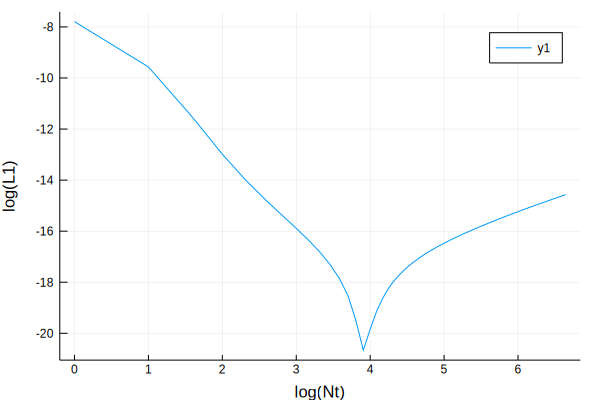

In [126]:
#println(NormT)
plot(log2.(collect(1:1:100)),log2.(NormT))
ylabel!("log(L1)")
xlabel!("log(Nt)")

In [97]:
(log(NormT[1])-log(NormT[6]))/(log(τ_array[1])-log(τ_array[6]))

2.587547332635011